In [1]:
from config_submit1 import * #Set the configuration file name
conf = config()

In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.11.0
True


In [4]:
import copy
import random
import time
from IPython.display import clear_output
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import timm
from timm.scheduler import CosineLRScheduler
from torch import nn
import torchaudio
import torchaudio.transforms as T
from torchinfo import summary
from torchlibrosa.augmentation import SpecAugmentation 
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm
import torch.nn.functional as F

In [5]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [6]:
root_path = "/data/datasets/TAU-urban-acoustic-scenes-2022-mobile-development/"
setup_path = root_path + "evaluation_setup/"

## checking csv data

In [7]:
train_csv = pd.read_table(setup_path + "fold1_train.csv")
val_csv = pd.read_table(setup_path + "fold1_evaluate.csv")
test_csv = pd.read_table(setup_path + "fold1_test.csv")

## Checking label

In [8]:
label_list = train_csv["scene_label"].unique()
print(label_list)

['airport' 'bus' 'metro' 'metro_station' 'park' 'public_square'
 'shopping_mall' 'street_pedestrian' 'street_traffic' 'tram']


In [9]:
devices = ([
        "a",
        "b",
        "c",
        "s1",
        "s2",
        "s3",
        "s4",
        "s5",
        "s6"
    ])
print(devices)

['a', 'b', 'c', 's1', 's2', 's3', 's4', 's5', 's6']


## Wav to MelSpectrogram

In [10]:
mel_spectrogram = T.MelSpectrogram(
    sample_rate=conf.sample_rate,
    n_fft=conf.n_fft,
    win_length=conf.win_length,
    hop_length=conf.hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=conf.n_mels,
    mel_scale="htk",
)

In [11]:
import pathlib,os,librosa
def load_dirs(dirs_path, resample_rate):
    all_paths = [path for path in pathlib.Path(os.path.expanduser(dirs_path)).rglob('*.wav')]
    all_paths = sorted(all_paths)
    all_paths_name = [str(p).rsplit("/", 1)[-1] for p in all_paths]


    def process_func(dir_file):
        sig, _ = librosa.load(dir_file, sr=resample_rate, mono=True)
        sig = torch.from_numpy(sig[np.newaxis])
        return sig

    return [process_func(p) for p in all_paths]
dirs = load_dirs(conf.dirs_path,conf.sample_rate)

def wav_to_mel_log10(filepath):
    wave, _ = torchaudio.load(filepath)
    
    return torch.log10(mel_spectrogram(wave) + 1e-10)


def normalize_std(melspec):
    return (melspec-torch.mean(melspec, dim=(2,3), keepdim=True)) / torch.std(melspec, dim=(2,3), keepdim=True)


def label_to_onehot(scene_label, label_list):
    label_temp = torch.zeros(label_list.shape)
    label_temp[label_list==scene_label] = 1
    return label_temp


def get_devices_no(filename, devices):
    return devices.index(filename.split('-')[-1][:-4])


def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow((spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)
    
    
def plot_confusion_matrix(true, predicted):
    cm = confusion_matrix(true, predicted, normalize="true")
    cm = np.around(cm,decimals=2)
    fig, ax = plt.subplots(figsize = (20,20))
    sns.heatmap(cm, square=True, cbar=False, annot=True, cmap="Blues")
    sns.set(font_scale=3) 
    
    ax.set_xticklabels(label_list, rotation=45,fontsize=40) 
    ax.set_yticklabels(label_list, rotation=0,fontsize=40,ha='right')
    plt.xlabel("True label",fontsize=40)
    plt.ylabel("Predicted label",fontsize=40)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fig.savefig("1.png",bbox_inches='tight')
   

    
def plot_device_wise_log_losses(loss_all, predicted_all, train_val_y, train_val_devices, devices):
    results_table = np.zeros((11, len(devices)+2))

    for label_id, _ in enumerate(label_list):
        label_indx = (train_val_y[:,label_id]==1)
        results_table[label_id, len(devices)+1] = (predicted_all[label_indx]==label_id).sum()/label_indx.sum()*100
        results_table[label_id, 0] = loss_all[label_indx].mean()

        for device_id, _ in enumerate(devices):
            device_indx = np.array(train_val_devices)==device_id
            device_wise_indx = np.array(label_indx)*(device_indx)
            results_table[label_id, device_id + 1] = loss_all[device_wise_indx].mean()
            results_table[10, device_id+1] = loss_all[device_indx].mean()

    results_table[10, len(devices)+1] = (predicted_all == torch.argmax(train_val_y, dim=1).clone().numpy()).sum()/len(predicted_all)*100
    results_table[10, 0] = loss_all.mean()

    df_results = pd.DataFrame(results_table, columns=["Log Loss", *devices, "Accuracy %"], index=[ *label_list, "Ovberall"])    
    display(df_results)  

## preprosessing

In [12]:
if conf.reuse:
    train_X = np.load(f"reuse/{conf.reusefolder}train_X.npy")
    train_X = torch.from_numpy(train_X.astype(np.float32)).clone()
    train_y = np.load(f"reuse/{conf.reusefolder}train_y.npy")
    train_y = torch.from_numpy(train_y.astype(np.float32)).clone()
    train_devices = np.load(f"reuse/{conf.reusefolder}train_devices.npy")
else:
    train_X = []
    train_y = []
    train_devices = []

    for filename, scene_label in zip(tqdm(train_csv['filename']), train_csv['scene_label']):
        x,_ = torchaudio.load(root_path + filename)
        if device == 'a' and torch.rand(1) < conf.prob:
            # choose a DIR at random
            dir_idx = int(np.random.randint(0, len(dirs)))
            dir = dirs[dir_idx]

            x = convolve(x, dir, 'full')[:, :x.shape[1]]
            x = torch.from_numpy(x)
        train_spec = torch.log10(mel_spectrogram(x) + 1e-10)
        train_X.append(train_spec )
        train_y.append(label_to_onehot(scene_label, label_list))
        train_devices.append(get_devices_no(filename, devices))

    train_X = torch.stack(train_X)   
    train_y = torch.stack(train_y)  
    
    
    np.save(f"reuse/{conf.reusefolder}train_X.npy", train_X)
    np.save(f"reuse/{conf.reusefolder}train_y.npy", train_y)
    np.save(f"reuse/{conf.reusefolder}train_devices.npy", train_devices)

print(train_X.shape)

torch.Size([139620, 1, 256, 65])


#### Validation data

In [13]:
if conf.reuse:
    val_X = np.load(f"reuse/{conf.reusefolder}val_X.npy")
    val_X = torch.from_numpy(val_X.astype(np.float32)).clone()
    val_y = np.load(f"reuse/{conf.reusefolder}val_y.npy")
    val_y = torch.from_numpy(val_y.astype(np.float32)).clone()
    val_devices = np.load(f"reuse/{conf.reusefolder}val_devices.npy")
else:
    val_X = []
    val_y = []
    val_devices = []

    for filename, scene_label in zip(tqdm(val_csv["filename"]), val_csv["scene_label"]):
        mel_spec = wav_to_mel_log10(root_path + filename)
        val_X.append(mel_spec)
        val_y.append(label_to_onehot(scene_label, label_list))
        val_devices.append(get_devices_no(filename, devices))

    val_X = torch.stack(val_X)
    val_y = torch.stack(val_y)   

    
    np.save(f"reuse/{conf.reusefolder}val_X.npy", val_X)
    np.save(f"reuse/{conf.reusefolder}val_y.npy", val_y)
    np.save(f"reuse/{conf.reusefolder}val_devices.npy", val_devices)

In [14]:
print(val_X.shape)

torch.Size([29680, 1, 256, 65])


In [15]:
if conf.include_val:
    train_X = torch.cat((train_X, val_X), 0)
    train_y = torch.cat((train_y, val_y), 0)
    train_devices = np.concatenate((train_devices, val_devices), 0)

val_X = normalize_std(val_X)

In [16]:
ComputeDeltas = torchaudio.transforms.ComputeDeltas(win_length= 5)

In [17]:
val_X2 = ComputeDeltas(val_X)
val_X2 = normalize_std(val_X2)
val_X = torch.cat((val_X,val_X2), 1)

## dataloaders

In [18]:
# Create data loaders.
train_devices = np.array(train_devices)
train_devices = torch.from_numpy(train_devices)
val_devices = np.array(val_devices)
val_devices = torch.from_numpy(val_devices)

train_dataset = torch.utils.data.TensorDataset(train_X, train_y,train_devices)
val_dataset = torch.utils.data.TensorDataset(val_X, val_y)
test_dataset = torch.utils.data.TensorDataset(val_X, val_y,val_devices)
train_dataloader = DataLoader(train_dataset, batch_size=conf.batch_size, shuffle=True, num_workers=8)
val_dataloader = DataLoader(val_dataset, batch_size=conf.batch_size, shuffle=True, num_workers=8)

## Teacher Network

In [35]:
from BSRN import BSRNLayer

In [24]:
def channle_shuffle(x, groups=2):
    """Channel Shuffle"""

    bs, chnls, h, w = x.data.size()
    if chnls % groups:
        return x
    chnls_per_group = chnls // groups
    x = x.view(bs, groups, chnls_per_group, h, w)
    x = torch.transpose(x, 1, 2).contiguous()
    x = x.view(bs, -1, h, w)
    return x
class BSConvS(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.pw=nn.Conv2d(16,16,kernel_size=1,stride=1,padding=0)
        # depthwise
        self.dw = nn.Conv2d(16,16,kernel_size=2,stride=2,padding=0,groups=16)
        
    def forward(self, fea):
        fea = self.pw(fea)
        fea = self.dw(fea)
        return fea

In [25]:
from block import Mlp,ConvBlock,Block,FCUUp,FCU
from BSRN_student import BSConvU
from timm.models.layers import DropPath, trunc_normal_
class GRN(nn.Module):
    """
    global response normalization as introduced in https://arxiv.org/pdf/2301.00808.pdf
    """

    def __init__(self):
        super().__init__()
        self.gamma = nn.Parameter(torch.zeros(1))
        self.beta = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        # dequantize and quantize since torch.norm not implemented for quantized tensors
        gx = torch.norm(x, p=2, dim=(2, 3), keepdim=True)
        nx = gx / (gx.mean(dim=1, keepdim=True) + 1e-6)

        x = self.gamma * (x * nx) + self.beta + x
        return x
class BSConvLayer(nn.Module):
    def __init__(self, input, output):
        super(BSConvLayer,self).__init__()
        self.BSconv = BSConvU(input,output,3)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(input)
        self.grn = GRN()
    def forward(self,x):
        out = self.BSconv(x)
        out = self.relu(self.bn(x+out))
        return self.grn(out)

In [36]:
n_output = label_list.shape[0]
n_hidden = 100

class Model1(nn.Module):
    def __init__(self, n_output, n_hidden):
        super().__init__()
        self.cls_token = nn.Parameter(torch.zeros(1, 1,32))
        # Classifier head
        self.pooling = nn.AdaptiveAvgPool2d((3,1))
        self.conv_cls_head = nn.Linear(32*6, 10)
        
        self.conv1 = nn.Conv2d(2, 32, 2, stride=2, padding=0)
        self.conv2 = BSConvLayer(32,32)
        self.conv3 = BSConvLayer(32,32)
        self.conv7 = nn.Conv2d(32,32,1,stride=1,padding=0)
        self.bn =nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
       
        self.maxpool = nn.MaxPool2d((2,2))

        self.trans_patch_conv = nn.Conv2d(32, 32, kernel_size=2, stride=2, padding=0)
        self.trans_1 = Block(dim=32, num_heads=4, mlp_ratio=2., qkv_bias=False,
                             qk_scale=None, drop=0., attn_drop=0.)

        self.up = FCUUp(32,32)
        self.shuffle = channle_shuffle
        #self.flatten = nn.Flatten()
        #self.l1 = nn.Linear(3584, n_hidden) 
        #self.l2 = nn.Linear(n_hidden, n_output)
        
        
    def forward(self, x):
        B = x.shape[0]
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = self.relu(self.bn(self.conv1(x)))
        out =self.maxpool(x)
        x = self.relu(self.bn2(self.conv7(out)))
        x1 =self.conv2(x+out)
        x2 = self.conv3(self.maxpool(x1))
        x_t = self.trans_patch_conv(x1)
        x_t=x_t.flatten(2).transpose(1, 2)
        x_t = torch.cat([cls_tokens, x_t], dim=1)
        x_t = self.trans_1(x_t)
        X_T = self.up(x_t)
        NEW = torch.cat([X_T,x2],dim=1)
        NEW = self.shuffle(NEW,6)
        x_p = self.pooling(NEW).flatten(1)
        conv_cls = self.conv_cls_head(x_p)
        #x = self.flatten(x)
        #x = self.relu(self.l1(x))
        #x = self.dropout(x)
        #x = self.l2(x)
        return conv_cls
teacher_model = Model1(n_output, n_hidden)
n_output = label_list.shape[0]
n_hidden = 100

class Model(nn.Module):
    def __init__(self, n_output, n_hidden):
        super().__init__()
        #self.quant = torch.quantization.QuantStub()
        self.conv1 = nn.Conv2d(2, 32, 5, stride=1, padding=2)
        self.conv2 = BSRNLayer(num_feat=32)
        
        self.conv7 = nn.Conv2d(32,32,3,stride=1,padding=1)
        self.bn = nn.BatchNorm2d(32, eps=1e-03, momentum=0.01)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.maxpool1 = nn.MaxPool2d((3,2))
        self.maxpool2 = nn.MaxPool2d((6,4))
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(3584, n_hidden) 
        self.l2 = nn.Linear(n_hidden, n_output)
        #self.shortcut = nn.quantized.FloatFunctional()
        #self.dequant = torch.quantization.DeQuantStub()
        
    def forward(self, x):
        #x = self.quant(x)
        out = self.relu(self.bn(self.conv1(x)))
        x = self.conv2(out)
        out = self.maxpool1(x)
        #x = self.maxpool1(x) 
        
        #out = self.maxpool1(x)
        x = self.conv7(out)
        x = self.dropout(self.maxpool2(x))
        x = self.flatten(x)
        x = self.relu(self.l1(x))
        x = self.dropout(x)
        x = self.l2(x)
        return x

#teacher_model.qconfig = torch.quantization.get_default_qat_qconfig("qnnpack")

## Augmentation

In [19]:
from torch.distributions.beta import Beta
def mixstyle(x, p=0.5, alpha=0.1, eps=1e-6):
    if np.random.rand() > p:
        return x
    batch_size = x.size(0)

    # changed from dim=[2,3] to dim=[1,3] from channel-wise statistics to frequency-wise statistics
    f_mu = x.mean(dim=[1, 3], keepdim=True)
    f_var = x.var(dim=[1, 3], keepdim=True)

    f_sig = (f_var + eps).sqrt()  # compute instance standard deviation
    f_mu, f_sig = f_mu.detach(), f_sig.detach()  # block gradients
    x_normed = (x - f_mu) / f_sig  # normalize input
    lmda = Beta(alpha, alpha).sample((batch_size, 1, 1, 1)).to(x.device)  # sample instance-wise convex weights
    perm = torch.randperm(batch_size).to(x.device)  # generate shuffling indices
    f_mu_perm, f_sig_perm = f_mu[perm], f_sig[perm]  # shuffling
    mu_mix = f_mu * lmda + f_mu_perm * (1 - lmda)  # generate mixed mean
    sig_mix = f_sig * lmda + f_sig_perm * (1 - lmda)  # generate mixed standard deviation
    return x_normed * sig_mix + mu_mix  # denormalize input using the mixed statistics

#SpecAugment
spec_augmenter = SpecAugmentation(
            time_drop_width=2,
            time_stripes_num=2,
            freq_drop_width=2,
            freq_stripes_num=2)

In [20]:
if conf.DIFF_FREQ:
    diff_freq_list = pd.read_pickle(f"/data/jessy/my/reuse/{conf.reusefolder}diff_freq.pkl") 
    if conf.include_val:
        diff_freq_list_val = pd.read_pickle(f"/root/autodl-tmp/my/reuse/{conf.reusefolder}diff_freq_val.pkl") 
        diff_freq_list = pd.concat([diff_freq_list, diff_freq_list_val])
    display(diff_freq_list.head())

    dif_devices_train_list = [
            "b",
            "c",
            "s1",
            "s2",
            "s3",
        ]

    diff_freq_power = torch.from_numpy(np.stack(diff_freq_list["dif_freq"].values).astype(np.float32)).clone()
    
def apply_diff_freq(X, diff_freq_power, devices_no):
    if random.randrange(0, 13, 1) != 0: # 1/13skip
        for idx, (X_temp, device_no) in enumerate(zip(X, devices_no)):
            tmp = (device_no==0)*diff_freq_power[random.randrange(0, len(diff_freq_power), 1),:].unsqueeze(0).unsqueeze(2)
            tmp = torch.from_numpy(np.dot(torch.ones((X.shape[3],1)), tmp[:,:,0])).clone()
            X[idx,0,:,:] = X_temp[0,:,:] + tmp.T

    return X

,filename,device_name,dif_freq
0,audio/airport-lisbon-1000-40000-0-s3.wav,s3,"[-3.095399, -3.3226514, -3.330462, -3.3033876,..."
1,audio/airport-lisbon-1000-40000-1-s3.wav,s3,"[-2.8868806, -3.0076747, -3.1168506, -3.119839..."
2,audio/airport-lisbon-1000-40000-2-s3.wav,s3,"[-2.9250743, -3.136487, -3.330392, -3.2307718,..."
3,audio/airport-lisbon-1000-40000-3-s3.wav,s3,"[-3.2530935, -3.2384448, -3.2473083, -3.299482..."
4,audio/airport-lisbon-1000-40000-4-s3.wav,s3,"[-2.6990395, -3.0312977, -3.1872072, -3.167743..."


## Teacher Train loop

In [21]:
def train(dataloader, model, loss_fn, optimizer, t):
    size = len(dataloader.dataset)
    train_loss = 0
    n_train = 0
    correct = 0
    model.train()

    for batch, (X, y,devices) in enumerate(dataloader):
        
        if conf.MIXUP:
            X = mixstyle(X, p=0.2, alpha=0.3)
        if conf.DIFF_FREQ:
            X = apply_diff_freq(X, diff_freq_power, devices)
            
        X = normalize_std(X)  
        X2 = ComputeDeltas(X)
        X2 = normalize_std(X2)   
        X = torch.cat((X,X2),1)
        
        if conf.SPEC_AUG:
            X = spec_augmenter(X)
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        output = model(X)
        #pred = output[0]+output[1]
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        scheduler.step(t+1)
        train_loss += loss.item()
        
        _, predicted = torch.max(pred.detach(), 1)
        _, y_predicted = torch.max(y.detach(), 1)
        correct += (predicted == y_predicted).sum().item()
        
        n_train += len(X)
        if batch % 500 == 0:
            loss_current, acc_current, current = train_loss/n_train, correct/n_train, batch * len(X)
            print(f"Train Epoch: {t+1} loss: {loss_current:>7f}  accuracy: {acc_current:>7f} [{current:>5d}/{size:>5d}]")
    
    loss_current, acc_current = train_loss/n_train, correct/n_train   
    return loss_current, acc_current

In [22]:
def val(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    val_loss = 0
    n_val = 0
    correct = 0
    model.eval()
    with torch.no_grad():        
        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)
            
            output = model(X)
            #pred = output[0]+output[1]
            pred = model(X)
            loss = loss_fn(pred, y)

            val_loss += loss.item()
            
            _, predicted = torch.max(pred.detach(), 1)
            _, y_predicted = torch.max(y.detach(), 1)
            correct += (predicted == y_predicted).sum().item()
            
            n_val += len(X)
            if batch % 500 == 0:
                loss_current, acc_current, current = val_loss/n_val, correct/n_val, batch*len(X)
                print(f"Val Epoch: {t+1} loss: {loss_current:>7f}  accuracy: {acc_current:>7f} [{current:>5d}/{size:>5d}]")
                
    loss_current, acc_current = val_loss/n_val, correct/n_val
    return loss_current, acc_current

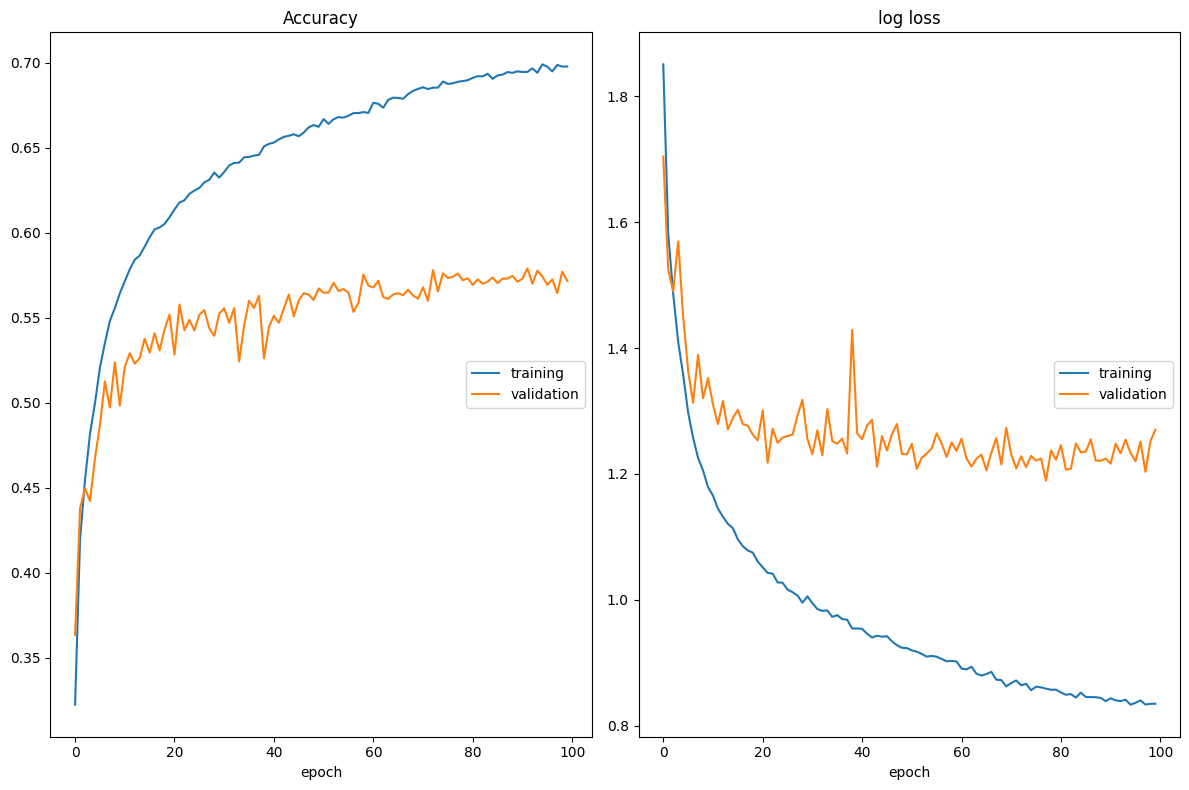

Accuracy
	training         	 (min:    0.322, max:    0.699, cur:    0.698)
	validation       	 (min:    0.364, max:    0.579, cur:    0.572)
log loss
	training         	 (min:    0.833, max:    1.851, cur:    0.835)
	validation       	 (min:    1.189, max:    1.704, cur:    1.270)


In [180]:
liveloss = PlotLosses()
max_acc = 0
teacher_model = teacher_model.to("cuda")
for t in range(conf.epochs):
    logs = {}
    train_loss, train_acc = train(train_dataloader, teacher_model, loss_fn, optimizer, t)
    val_loss, val_acc = val(val_dataloader, teacher_model, loss_fn)
    logs["log loss"] = train_loss
    logs["val_log loss"] = val_loss
    logs["acc"] = train_acc
    logs["val_acc"] = val_acc
    liveloss.update(logs)
    liveloss.send()
        
    if max_acc < val_acc:
        max_acc = val_acc
        torch.save(copy.deepcopy(teacher_model).state_dict(), "teacher_models/teacher_model.pt")

## 模型集成

In [37]:
class EnsembelerModel(nn.Module):
    def __init__(self, models):
        super(EnsembelerModel, self).__init__()
        self.models = nn.ModuleList(models)

    def forward(self, x):
        # ModuleList can act as an iterable, or be indexed using ints
        all_out = None
        for i, m in enumerate(self.models):
            out = m(x)
            if all_out is None:
                all_out = out
            else:
                all_out = out + all_out
        all_out = all_out / len(self.models)
        return all_out

In [38]:
def get_teacher_avg_ensemble(teachers_list=[], teachers_path="teacher_models"):
    models_list = [Model1(n_output, n_hidden),Model(n_output, n_hidden),Model(n_output, n_hidden),Model(n_output, n_hidden)]

    for i, tid in enumerate(teachers_list):
        ckpt = torch.load(f"{teachers_path}/teacher_model{tid}.pt")
        models_list[i].load_state_dict(ckpt)
    model = EnsembelerModel(models_list)
    #print(model)
    return model

In [39]:
#ENSEMBLE = Model(n_output, n_hidden)
ENSEMBLE = get_teacher_avg_ensemble(teachers_list=[0,1,2,3])

BSConvU
BSConvU
BSConvU


## 学生网络

In [34]:
from block import Mlp,ConvBlock,Block,FCUUp
from BSRN_student import BSConvU
from timm.models.layers import DropPath, trunc_normal_
class GRN(nn.Module):
    """
    global response normalization as introduced in https://arxiv.org/pdf/2301.00808.pdf
    """

    def __init__(self):
        super().__init__()
        self.gamma = nn.Parameter(torch.zeros(1))
        self.beta = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        # dequantize and quantize since torch.norm not implemented for quantized tensors
        gx = torch.norm(x, p=2, dim=(2, 3), keepdim=True)
        nx = gx / (gx.mean(dim=1, keepdim=True) + 1e-6)

        x = self.gamma * (x * nx) + self.beta + x
        return x
class BSConvLayer(nn.Module):
    def __init__(self, input, output):
        super(BSConvLayer,self).__init__()
        self.BSconv = BSConvU(input,output,3)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(input)
        self.grn = GRN()
    def forward(self,x):
        out = self.BSconv(x)
        out = self.relu(self.bn(x+out))
        return self.grn(out)

class Conformer(nn.Module):

    def __init__(self, patch_size=10, in_chans=2, num_classes=10, base_channel=16, channel_ratio=2, num_med_block=0,
                 dim=28, depth=3, num_heads=4, mlp_ratio=2., qkv_bias=False, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.):

        # Transformer
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.dim =dim  # num_features for consistency with other models
        assert depth % 3 == 0

        self.cls_token = nn.Parameter(torch.zeros(1, 1, dim))
        #self.trans_dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule

        # Classifier head
        self.pooling = nn.AdaptiveAvgPool2d((3,1))
        self.conv_cls_head = nn.Linear(dim*6, num_classes)

        # Stem stage: get the feature maps by conv block (copied form resnet.py)
        self.conv2 = nn.Conv2d(dim,dim,kernel_size=1,stride=1,padding=0)
        self.bn1 =nn.BatchNorm2d(dim)
        self.bn2=nn.BatchNorm2d(dim)
        self.conv1 = nn.Conv2d(2,dim,kernel_size=2,stride=2,padding=0)

        
        self.act1 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((2,2))  
        #self.dropout = nn.Dropout(p=0.03)

        self.conv3 = BSConvLayer(dim,dim)
        self.conv4 = BSConvLayer(dim,dim)
        self.trans_patch_conv = nn.Conv2d(dim, dim, kernel_size=2, stride=2, padding=0,groups=4)
        
        self.trans_1 = Block(dim=dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias,
                             qk_scale=qk_scale, drop=drop_rate, attn_drop=attn_drop_rate)

        self.up = FCU(dim,dim)
        self.shuffle = channle_shuffle
        
        trunc_normal_(self.cls_token, std=.02)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1.)
            nn.init.constant_(m.bias, 0.)
        elif isinstance(m, nn.GroupNorm):
            nn.init.constant_(m.weight, 1.)
            nn.init.constant_(m.bias, 0.)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'cls_token'}


    def forward(self, x):
        B = x.shape[0]
        cls_tokens = self.cls_token.expand(B, -1, -1)

        # pdb.set_trace()
        # stem stage [N, 2, 256, 65] -> [N, 15, 64, 16]
        x_base1=self.act1(self.bn1(self.conv1(x)))
        x_base1 = self.maxpool(x_base1)
        x_base2 =self.act1(self.bn2(self.conv2(x_base1)))
        x_base = self.maxpool(self.conv3(x_base1+x_base2)) #[N,16,21,11]
        # 1 stage
        x = self.conv4(x_base)
        x_t = self.trans_patch_conv(x_base)
        x_t = self.shuffle(x_t,2)
        x_t=x_t.flatten(2).transpose(1, 2)
        x_t = torch.cat([cls_tokens, x_t], dim=1)
        x_t = self.trans_1(x_t)
        
        #特征交流
        X_T = self.up(x_t)
        NEW = torch.cat([X_T,x],dim=1)
        NEW = self.shuffle(NEW,4)

        x_p = self.pooling(NEW).flatten(1)
        conv_cls = self.conv_cls_head(x_p)
        return conv_cls

model = Conformer()
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', n_parameters)
summary(model, input_size=(1, 2,256,65), verbose=0)

number of params: 13314


Layer (type:depth-idx)                   Output Shape              Param #
Conformer                                [1, 10]                   28
├─Conv2d: 1-1                            [1, 28, 128, 32]          252
├─BatchNorm2d: 1-2                       [1, 28, 128, 32]          56
├─ReLU: 1-3                              [1, 28, 128, 32]          --
├─MaxPool2d: 1-4                         [1, 28, 64, 16]           --
├─Conv2d: 1-5                            [1, 28, 64, 16]           812
├─BatchNorm2d: 1-6                       [1, 28, 64, 16]           56
├─ReLU: 1-7                              [1, 28, 64, 16]           --
├─BSConvLayer: 1-8                       [1, 28, 64, 16]           --
│    └─BSConvU: 2-1                      [1, 28, 64, 16]           --
│    │    └─Conv2d: 3-1                  [1, 28, 64, 16]           784
│    │    └─Conv2d: 3-2                  [1, 28, 64, 16]           280
│    └─BatchNorm2d: 2-2                  [1, 28, 64, 16]           56
│    └─ReLU

## 训练

In [40]:
#teacher_model.load_state_dict(torch.load("teacher_models/teacher_model3.pt"))
T =conf.temperature
kl_div_loss = nn.KLDivLoss(log_target=True, reduction="sum")   # KL Divergence loss for soft targets
log_softmax = nn.LogSoftmax(dim=-1)

lamda = 0.226
optimizer = torch.optim.RAdam(model.parameters(), lr=0.002)
scheduler = CosineLRScheduler(optimizer, t_initial=100, lr_min=1e-6, warmup_t=5, warmup_lr_init=5e-5, warmup_prefix=True)
model=model.to(device)
loss_fn = nn.CrossEntropyLoss(reduction="sum")

In [41]:
def student_train(dataloader, model, teacher_model,optimizer,t):
    size = len(dataloader.dataset)
    train_loss = 0
    n_train = 0
    correct = 0
    model.train()

    for batch, (X, y,devices) in enumerate(dataloader):
        
        if conf.MIXUP:
            X = mixstyle(X, p=0.2, alpha=0.3)
        if conf.DIFF_FREQ:
            X = apply_diff_freq(X, diff_freq_power,devices)

       
        
        X = normalize_std(X)  
        X2 = ComputeDeltas(X)
        X2 = normalize_std(X2)   
        X = torch.cat((X,X2),1)
        
        if conf.SPEC_AUG:
            X = spec_augmenter(X)

        X, y= X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        label_loss = loss_fn(pred,y)

        # getting teacher predictions
        with torch.no_grad():
            y_hat_teacher = teacher_model(X)
    
        # Temperature adjusted probabilities of teacher and student
        with torch.cuda.amp.autocast():
            y_soft_teacher = log_softmax(y_hat_teacher  / T)
            y_soft_student = log_softmax(pred / T)
       
        # distillation loss
        soft_targets_loss = kl_div_loss(y_soft_student,y_soft_teacher).mean()
        loss = (1-lamda)*soft_targets_loss + lamda*label_loss
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        scheduler.step(t+1)
        train_loss += loss.item()
        
        _, predicted = torch.max(pred.detach(), 1)
        _, y_predicted = torch.max(y.detach(), 1)
        correct += (predicted == y_predicted).sum().item()
        
        n_train += len(X)
        if batch % 500 == 0:
            loss_current, acc_current, current = train_loss/n_train, correct/n_train, batch * len(X)
            print(f"Train Epoch: {t+1} loss: {loss_current:>7f}  accuracy: {acc_current:>7f} [{current:>5d}/{size:>5d}]")
    loss_current, acc_current = train_loss/n_train, correct/n_train   
   
    return loss_current, acc_current

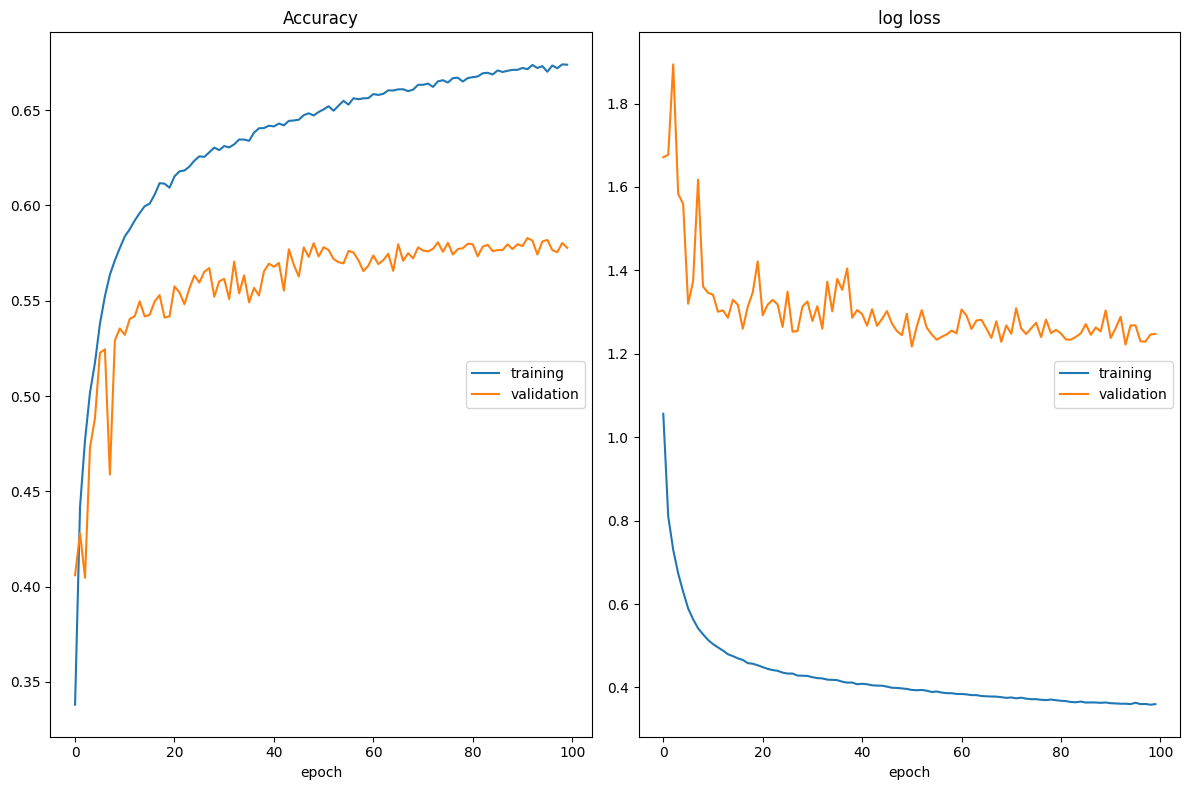

Accuracy
	training         	 (min:    0.338, max:    0.674, cur:    0.674)
	validation       	 (min:    0.405, max:    0.583, cur:    0.578)
log loss
	training         	 (min:    0.359, max:    1.056, cur:    0.360)
	validation       	 (min:    1.217, max:    1.894, cur:    1.248)


In [42]:
liveloss = PlotLosses()
ENSEMBLE.to('cuda')
max_acc = 0
for t in range(conf.epochs):
    logs = {}
    train_loss, train_acc = student_train(train_dataloader, model,ENSEMBLE,optimizer, t) #train(train_dataloader, model, loss_fn, optimizer, t)
    val_loss, val_acc = val(val_dataloader, model, loss_fn)
    logs["log loss"] = train_loss
    logs["val_log loss"] = val_loss
    logs["acc"] = train_acc
    logs["val_acc"] = val_acc
    liveloss.update(logs)
    liveloss.send()
    if max_acc < val_acc:
        max_acc = val_acc
        torch.save(copy.deepcopy(model).state_dict(), "model/max1.pt")

## Validation Results

In [48]:
batch_size = 1
val_result_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
loss_fn_inference = nn.CrossEntropyLoss(reduction="none")
#model = model.to("cpu")

In [52]:
def inference(dataloader, model, loss_fn, device):
    loss_all = []
    predicted_all = []
    correct=[0]*9
    cnt=[0]*9
    cor=[0.]*9
    model.eval()
    with torch.no_grad():        
        for batch, (X, y,devices) in enumerate(dataloader):
            X, y= X.to(device), y.to(device)
            
            output = model(X)
            pred = output
            #pred = output[0]+output[1]
            
            loss = loss_fn(pred, y)

            _, predicted = torch.max(pred.detach(), 1)
            _, y_predicted = torch.max(y.detach(), 1)
            correct[devices] += (predicted == y_predicted).sum().item()
            cnt[devices] += 1
            cor[devices]=correct[devices] /cnt[devices]
            
            loss_all.append(loss)
            predicted_all.append(predicted)
    print(correct,cnt,cor)
    return torch.flatten(torch.stack(loss_all)).numpy(), torch.flatten(torch.stack(predicted_all)).numpy()

In [165]:
start_time = time.time()
loss_all, predicted_all = inference(val_result_dataloader,model, loss_fn_inference, "cpu")
print('run time {:.5f} s'.format(time.time()-start_time))

[1983, 1801, 1902, 1783, 1817, 1954, 1738, 1772, 1593] [3300, 3290, 3290, 3300, 3300, 3300, 3300, 3300, 3300] [0.600909090909091, 0.5474164133738602, 0.5781155015197569, 0.5403030303030303, 0.5506060606060607, 0.5921212121212122, 0.5266666666666666, 0.536969696969697, 0.4827272727272727]
run time 98.26184 s


,Log Loss,a,b,c,s1,s2,s3,s4,s5,s6,Accuracy %
airport,1.352934,1.026173,1.335548,1.164474,1.438291,1.266263,1.372004,1.573916,1.393018,1.606193,51.013519
bus,1.069779,0.512993,1.229780,0.490781,0.917056,1.045836,0.785530,1.362089,1.776040,1.507910,63.804710
metro,1.414283,1.380207,1.507890,1.284489,1.724315,1.299212,1.223795,1.225600,1.598073,1.484967,46.094276
metro_station,1.616372,1.580060,1.799626,1.798389,1.741892,1.551116,1.193386,1.791750,1.643554,1.447580,45.185184
park,0.846784,0.288105,0.186623,0.363757,0.972426,0.993003,0.809918,0.998474,0.959767,2.048986,76.296295
public_square,1.730449,1.507007,1.793555,1.485809,1.809146,1.583164,1.423561,1.921443,1.697742,2.352615,42.356899
shopping_mall,1.074214,1.545950,1.133961,1.178114,1.272118,0.926773,1.301035,1.128896,0.498619,0.682457,62.828278
street_pedestrian,2.176621,1.912187,2.385677,2.429758,1.747499,2.113601,2.039111,2.465944,2.455271,2.040544,28.383837
street_traffic,0.834355,0.833340,0.952965,0.978893,0.602801,0.656519,0.961360,0.773859,0.519191,1.230265,75.589218
tram,1.351380,1.062912,1.357547,1.254943,1.012835,1.280187,0.728329,1.824212,1.725077,1.913455,59.087837


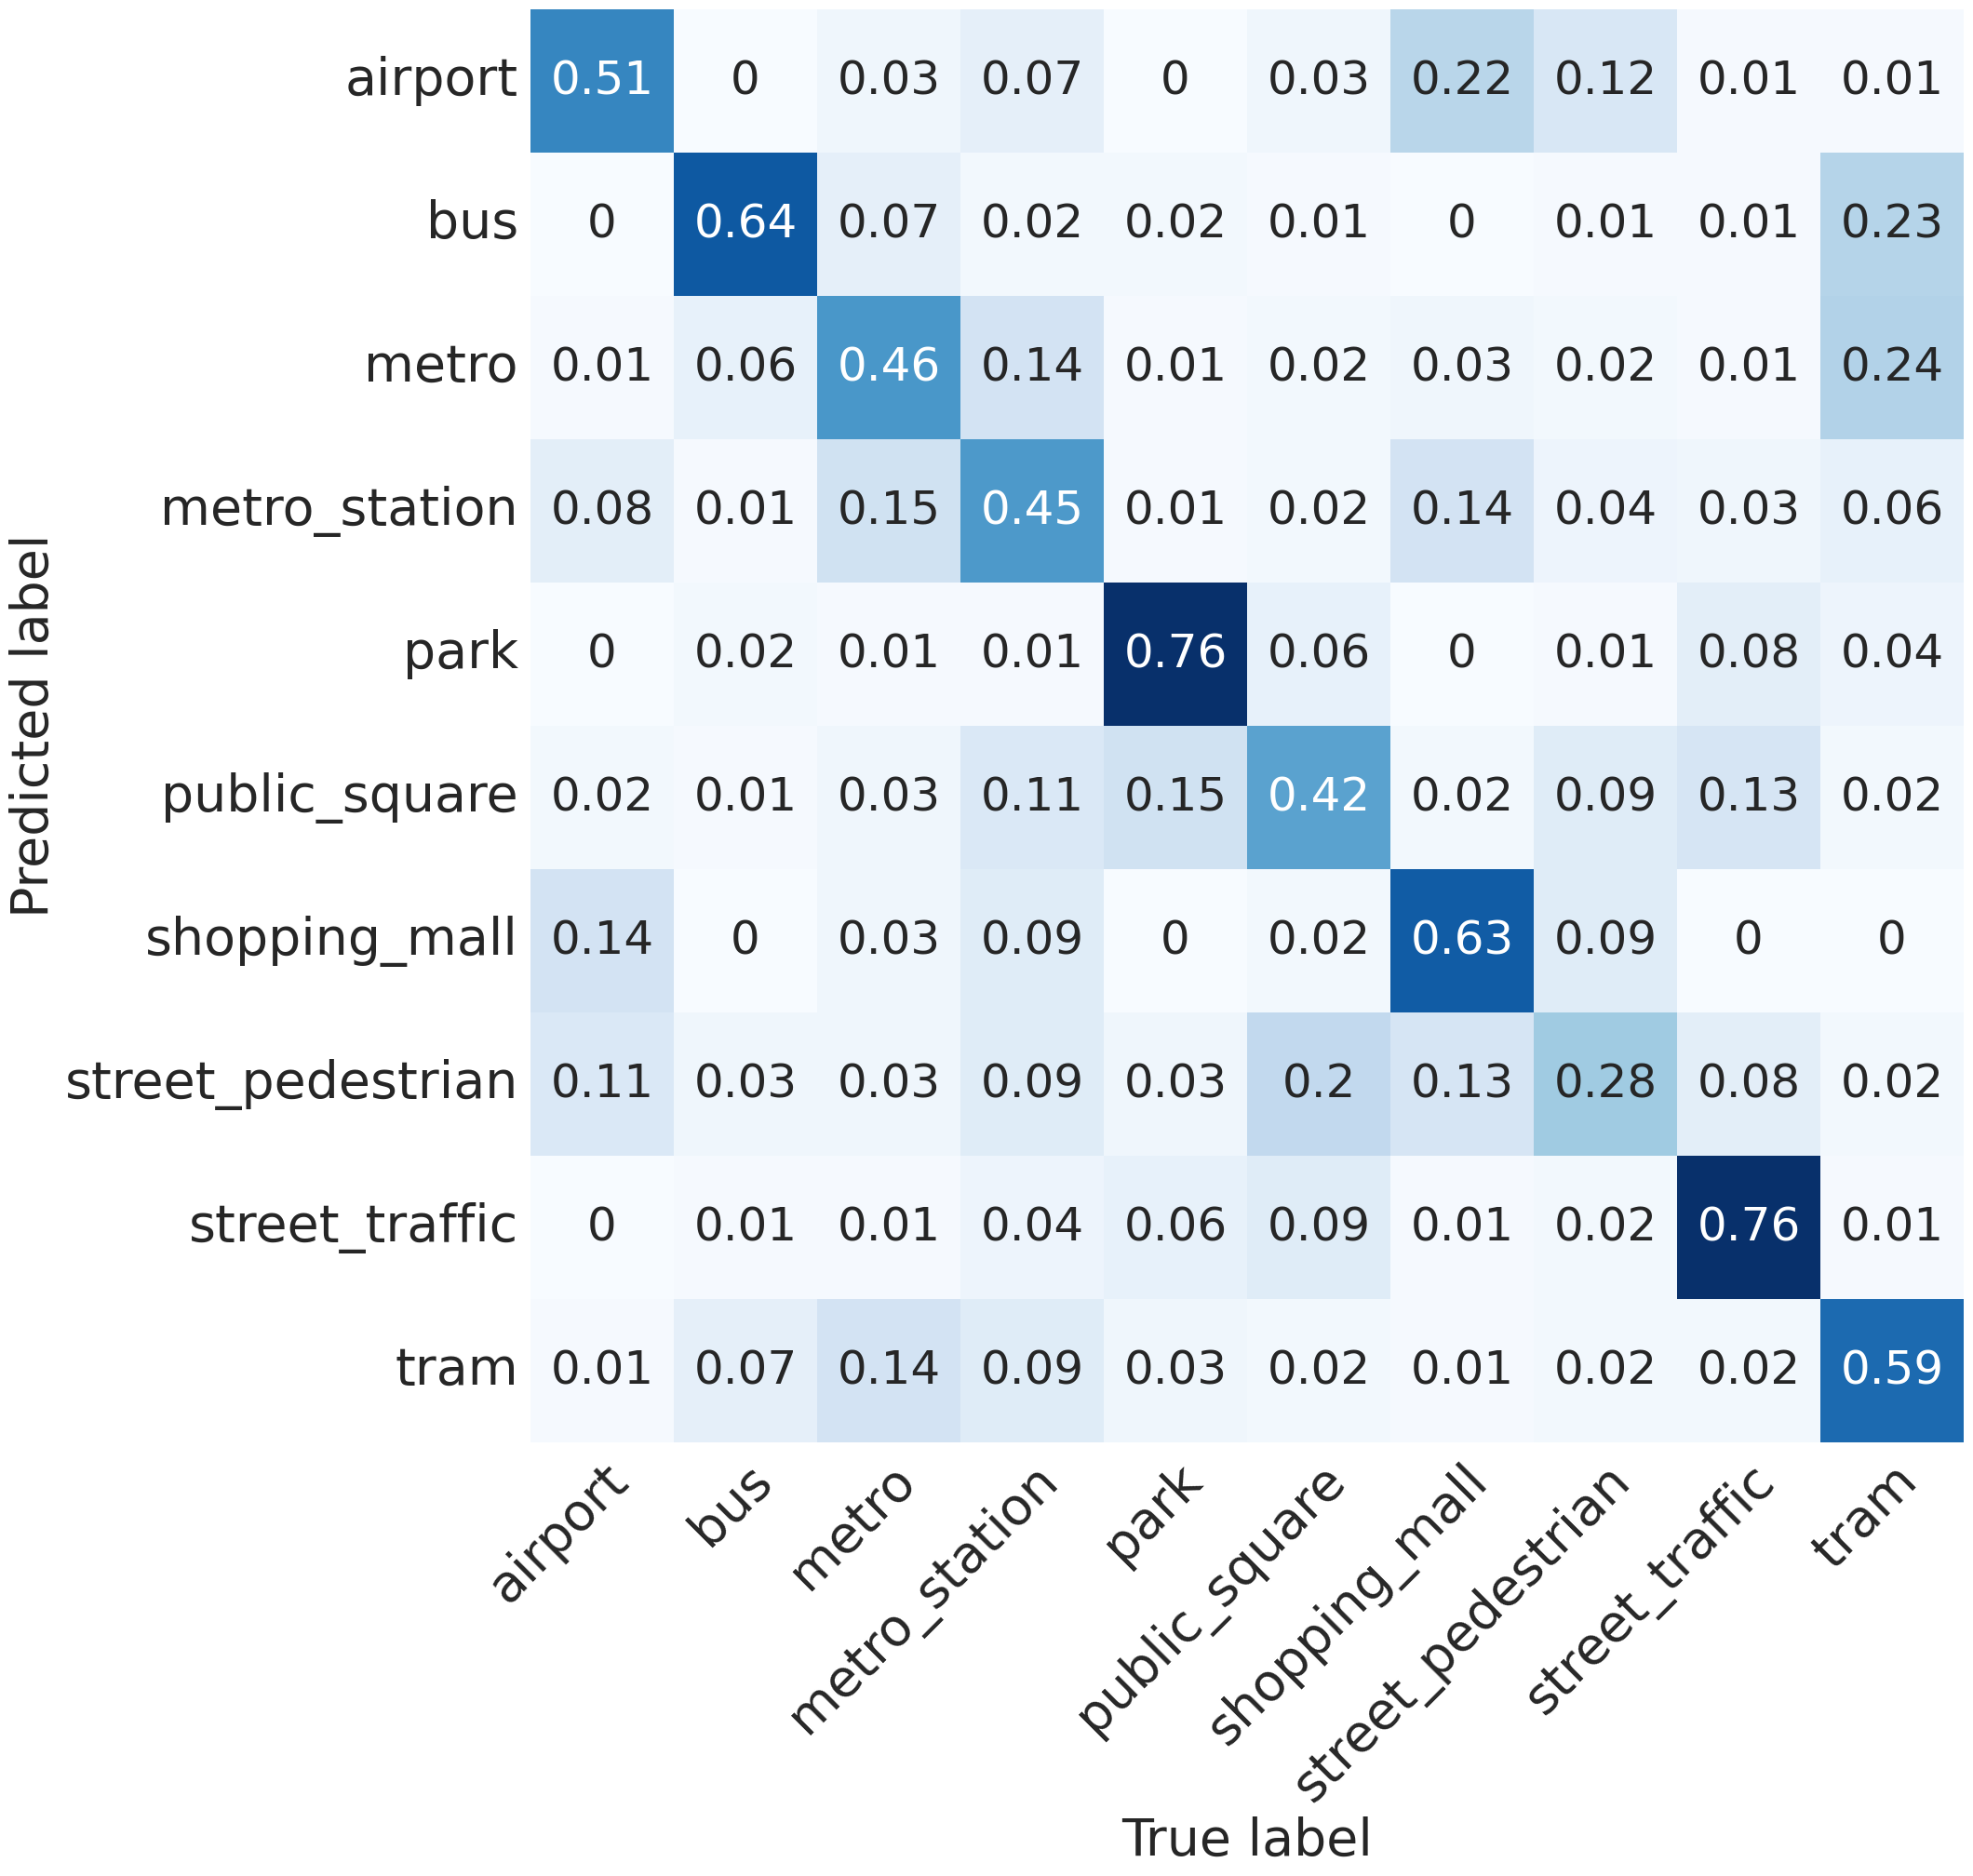

In [166]:
plot_device_wise_log_losses(loss_all, predicted_all, val_y, val_devices, devices)
plot_confusion_matrix(torch.argmax(val_y.detach(), 1), predicted_all)